# **Classification**

In this chapter, we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau.  

Each image is labeled with the digit it represents.  

---

## **Installations**

In [2]:
! pip install matplotlib numpy pandas scipy scikit-learn seaborn

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

%matplotlib inline

---

## **Fetch data**

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
# Sort data

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [6]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
X, y = mnist["data"], mnist["target"]

In [7]:
# Each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black)

print(f"There are {X.shape[0]} images and each image has {X.shape[1]} features")

There are 70000 images and each image has 784 features


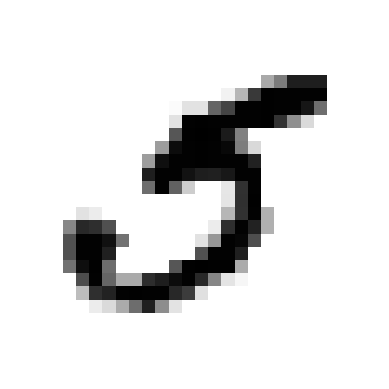

Check, y value: 5


In [8]:
# Look at one digit from the dataset.
# Grab an instance’s feature vector, reshape it to a 28×28 array.

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()
print(f"Check, y value: {y[36000]}")

---

## **Train, test split**

The MNIST dataset is already split into a training set (the first 60,000 images) and a test set (the last 10,000 images)

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

---

## **Suffle training data**

Suffling the training set guarantees that all cross-validation folds will be similar (you don’t want one fold to be missing some digits).  
Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row.  
Shuffling the dataset ensures that this won’t happen.

In [10]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### **Binary classifier**

Training on just being able to identify the number 5 or not 5

Stochastic Gradient Descent (SGD) classifier has the advantage of being capable of handling very large datasets efficiently.  
This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning).  
The SGDClassifier relies on randomness during training (hence the name “stochastic”). If you want reproducible results, you should set the random_state parameter.

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

/opt/miniconda3/envs/hands-on-ml/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(max_iter=5, random_state=42)

In [13]:
# make predictions

some_digit = X[36000] # this is 5
sgd_clf.predict([some_digit])

array([False])

In [14]:
y_train_5

array([False, False, False, ..., False, False, False], shape=(60000,))

---

## **Measuring performance**

In [15]:
from sklearn.model_selection import cross_val_score

# in regression we score based on neg_mean_squared_error
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

/opt/miniconda3/envs/hands-on-ml/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/hands-on-ml/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/hands-on-ml/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.95675, 0.9575 , 0.95935])

Accuracy is high as number 5 appears in only about 10% of the images.  
This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

---

If you want more control over cross-validation you may want to implement your own version of <code>cross_val_score()</code>.  

The <code>StratifiedKFold</code> class performs stratified sampling to produce folds that contain a representative ratio of each class.  
At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold (each sample appears in exactly one validation set per cycle).  
Then it counts the number of correct predictions and outputs the ratio of correct predictions.  

In [16]:
# FOR DEMONSTRATION PURPOSES ONLY

# Implementing cross_val_score manually for greater customisation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/opt/miniconda3/envs/hands-on-ml/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.9191


/opt/miniconda3/envs/hands-on-ml/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.88515
0.9357


/opt/miniconda3/envs/hands-on-ml/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


---

### **Confusion matrix**

Just like the <code>cross_val_score()</code> function, <code>cross_val_predict()</code> performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold.  

Trains a separate <code>SGDClassifier</code> model for each fold using (k-1)/k of the data.

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

/opt/miniconda3/envs/hands-on-ml/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/hands-on-ml/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/hands-on-ml/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Rows in the confusion matrix represent an actual class, while columns represent a predicted class.

In [26]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_train_5, y_train_pred))
print("-"*40)
print("H0 is selecting a number other than 5, and H1 is selecting 5")

tn = confusion_matrix(y_train_5, y_train_pred)[0][0]
fp = confusion_matrix(y_train_5, y_train_pred)[0][1]
fn = confusion_matrix(y_train_5, y_train_pred)[1][0]
tp = confusion_matrix(y_train_5, y_train_pred)[1][1]

print("-"*40)
print(f"TN: Predicted not 5 and it actually was not 5 in {tn} instances")
print(f"FP: Predicted 5 and it actually was not 5 in {fp} instances")
print(f"FN: Predicted not 5 and it actually was 5 in {fn} instances")
print(f"TP: Predicted 5 and it actually was 5 in {tp} instances")

[[52996  1583]
 [  945  4476]]
----------------------------------------
H0 is selecting a number other than 5, and H1 is selecting 5
----------------------------------------
TN: Predicted not 5 and it actually was not 5 in 52996 instances
FP: Predicted 5 and it actually was not 5 in 1583 instances
FN: Predicted not 5 and it actually was 5 in 945 instances
TP: Predicted 5 and it actually was 5 in 4476 instances


TP is the number of true positives, and FP is the number of false positives.  

A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = 1/1 = 100%). This would not be very useful since the classifier would ignore all but one positive instance. So precision is typically used along with recall (sensitivity / true positive rate (TPR)): this is the ratio of positive instances that are correctly detected by the classifier.

![Screenshot](confusion_matrix.png)

In [29]:
from sklearn.metrics import precision_score, recall_score

In [45]:
print("-"*40)
print("Precision")
print("-"*40)
print("Precision:", precision_score(y_train_5, y_train_pred))
print("tp/(tp+fp)")
print("Check:", tp/(tp+fp))
print("-"*40)
print("Recall")
print("-"*40)
print("Recall:", recall_score(y_train_5, y_train_pred))
print("tp/(tp+fn)")
print("Check:", tp/(tp+fn))
print("-"*40)
print(f"The model detects the number 5 correctly {(tp/(tp+fp))*100:.2f}% of the time, and it detects {(tp/(tp+fn))*100:.2f}% of the 5's")

----------------------------------------
Precision
----------------------------------------
Precision: 0.7387357649777191
tp/(tp+fp)
Check: 0.7387357649777191
----------------------------------------
Recall
----------------------------------------
Recall: 0.8256779192030991
tp/(tp+fn)
Check: 0.8256779192030991
----------------------------------------
The model detects the number 5 correctly 73.87% of the time, and it detects 82.57% of the 5's


In [47]:
# F1 score is a harmonic mean meaning it gives much more weight to low values.

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7797909407665505

**Precision**: out of the 5's we predicted how many did we get right?  
**Recall**: out of all the actual 5's how many did we get right.  

### **Precision/Recall trade-off**

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions.  
Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want.  
Changing the threshold changes precision/recall.  

In [48]:
# specify that you want to return decision scores instead of predictions

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

/opt/miniconda3/envs/hands-on-ml/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/hands-on-ml/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/hands-on-ml/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [49]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


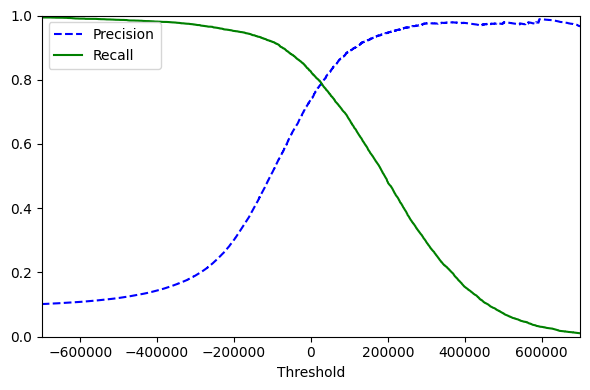

In [57]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plt.figure(figsize=(6, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

Saving figure precision_vs_recall_plot


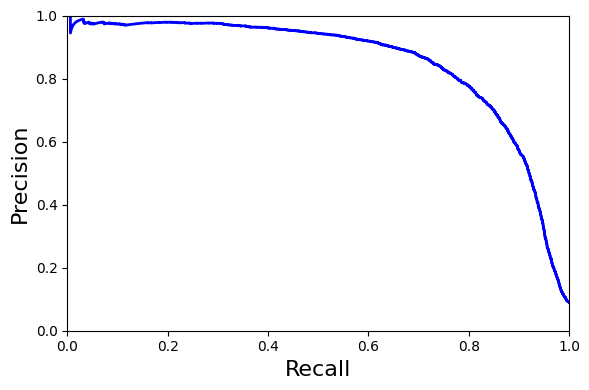

In [56]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(6, 4))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

In [ ]:
# say you want precision of 90%
# looking at the decision function you need a threshhold above 70000
y_train_pred_90 = y_scores > 70000

In [66]:
print("Precision:", precision_score(y_train_5, y_train_pred_90))
print("Recall:", recall_score(y_train_5, y_train_pred_90))

Precision: 0.8547157482030059
Recall: 0.7238516878804648


**Insight**: Setting a high threshhold increases precision (but at the expense of recall).

### **ROC curve**

Similar to the precision/recall curve.  
But instead of plotting precision versus recall, the ROC curve plots the TPR/recall (TP / (TP + FN)) against the false positive rate.  

FPR is the ratio of negative instances that are incorrectly classified as positive (FP / (FP + TN)).  
FPR equals one minus the TNR (TN / (TN + FP)), which is the ratio of negative instances that are correctly classified as negative.  
TNR is also called specificity.  

Hence the ROC curve plots sensitivity (recall) versus 1 – specificity.  

In [68]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

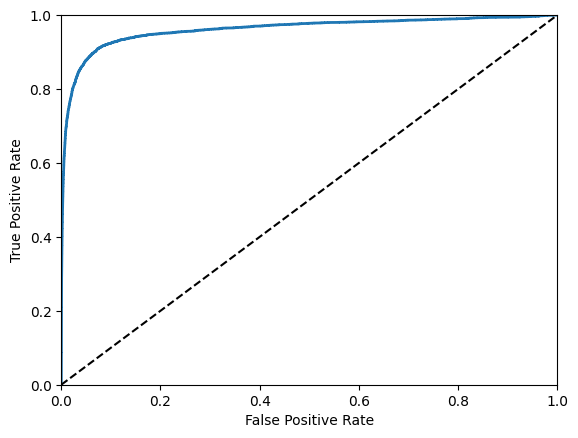

In [69]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

**Insight**: Increasing recall -> reduces false negatives -> increases false postives (reducing precision) -> increases FPR

The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).  

### **ROC AUC**

One way to compare classifiers is to measure the area under the curve (AUC).  
A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [70]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9611568735194037)